# Water surface project 💦

# 1. **Installation**  

**connect colab to GoogleDrive** 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls 

drive  sample_data


**clone MAsk rcnn from `matterport`**


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 17.61 MiB/s, done.
Resolving deltas: 100% (565/565), done.


**Unzip rcnn model from `matterport`**


In [ ]:
!unzip /content/Mask_RCNN-master.zip

unzip:  cannot find or open /content/Mask_RCNN-master.zip, /content/Mask_RCNN-master.zip.zip or /content/Mask_RCNN-master.zip.ZIP.


In [ ]:
!pip install tensorflow==1.13.1
#%tensorflow_version 1.x
!pip install --upgrade h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 79 kB/s 
     |████████████████████████████████| 3.2 MB 56.3 MB/s 
     |████████████████████████████████| 367 kB 74.2 MB/s 
     |████████████████████████████████| 50 kB 8.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
ERROR: pip's dependency resolver does not currently tak

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 4.9 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
#%tensorflow_version 1.x
#!pip install --upgrade h5py==2.10.0

ValueError: ignored

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.2


## 2. **Import libraries**

In [ ]:

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import shutil
import zipfile
import os
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display


In [ ]:
pwd

'/content'

In [ ]:
ls

drive/  sample_data/


In [ ]:
cd /content

/content


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master

/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master


▶ Install Keras ver 2.0.8

In [ ]:
!pip install keras==2.0.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Keras-2.0.8-py2.py3-none-any.whl (276 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from PIL import Image, ImageDraw


# 3. **Helper Functions** 

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, annotation_json, images_dir, dataset_type="train"):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """

        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()


        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']

            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(
                    class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}

        # Split the dataset, if train, get 90%, else 10%
        len_images = len(coco_json['images'])
        if dataset_type == "train":
            img_range = [int(len_images / 9), len_images]
        else:
            img_range = [0, int(len_images / 9)]

        for i in range(img_range[0], img_range[1]):
            image = coco_json['images'][i]
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        #print("Class_ids, ", class_ids)
        return mask, class_ids

    def count_classes(self):
        class_ids = set()
        for image_id in self.image_ids:
            image_info = self.image_info[image_id]
            annotations = image_info['annotations']

            for annotation in annotations:
                class_id = annotation['category_id']
                class_ids.add(class_id)

        class_number = len(class_ids)
        return class_number




        
def load_image_dataset(annotation_path, data_path, dataset_type):
    train_data = CustomDataset()
    train_data.load_custom(annotation_path, data_path, dataset_type)
    train_data.prepare()
    return train_data
    
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"

    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # number of classes (we would normally add +1 for the background)
    NUM_CLASSES = 1 + 1

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Learning rate
    LEARNING_RATE = 0.001

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.85

    # setting Max ground truth instances
    MAX_GT_INSTANCES = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512



# 3. **Load The  Dataset**

Need to upload the annotation file with json format and images dataset

In [ ]:
train = load_image_dataset(os.path.join("/content/drive/MyDrive/Colab Notebooks/model_water _surface/ANNOTATION_14-7.json"), "/content/drive/MyDrive/Colab Notebooks/model_water _surface/images_", "train")
test = load_image_dataset(os.path.join("/content/drive/MyDrive/Colab Notebooks/model_water _surface/ANNOTATION_14-7.json"), "/content/drive/MyDrive/Colab Notebooks/model_water _surface/images_", "test")
class_number = train.count_classes()
print('Train: %d' % len(train.image_ids))
print('test: %d' % len(test.image_ids))
print("Classes: {}".format(class_number))

Train: 163
test: 20
Classes: 1


In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master'

# 4.**Train Model**

Note ⚠ : you may need to install some tools 

In [ ]:
!pip install scikit-image==0.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

ERROR: Operation cancelled by user


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:

# save logs and trained model
model_dir= "/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master/logs"
# Local path to trained weights file

COCO_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/mask_rcnn_coco.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
config = myMaskRCNNConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=model_dir)
init_with = "coco"  # imagenet, coco, or last
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    print(COCO_MODEL_PATH)
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
# train the model
model.train(train, test,
        learning_rate=config.LEARNING_RATE,
        epochs=4,# change the epochs from here 
        layers='heads')



Output hidden; open in https://colab.research.google.com to view.

`Trained Model Path`

In [ ]:
model_path="/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master/logs/object20220704T0350/mask_rcnn_object_0003.h5"

 **validation data**


In [ ]:

def load_model():
    config = myMaskRCNNConfig()


    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference",
                              config=config,
                              model_dir="/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master/logs")

    # Get path to saved weights
    # Either set a specific path or find last trained weights
    model_path = os.path.abspath("/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master/logs/mask_rcnn_maskrcnn_config_0001.h5")
    #model_path = model.find_last()

    # Load trained weights
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)
    return model, config

model_, inference_config =load_model()
def test_random_test_image(model_, test, inference_config):
    image_id = random.choice(test.image_ids)
    print(image_id)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(test, inference_config,
                               image_id, use_mini_mask=False)
    # Model result
    print("Trained model result")
    results = model_.detect([original_image], verbose=1)
    r = results[0]
    _, ax = plt.subplots(1, 1, figsize=(8 * 1, 1 * 1))
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                test.class_names, r['scores'], ax= ax  , show_bbox=False)

    print("Annotation")
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                test.class_names, figsize=(5, 5))





Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master/logs/object20220704T0350/mask_rcnn_object_0003.h5
Re-starting from epoch 3


7
Trained model result
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
Annotation


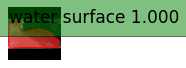

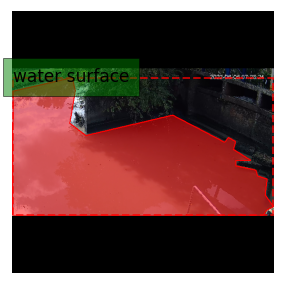

In [ ]:
test_random_test_image(model_,test,inference_config)

# 5 **Test The Model** 

In [ ]:
cd ..

/content/drive/MyDrive/Colab Notebooks/model_water _surface/output_frames


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master/mrcnn

/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master/mrcnn


In [ ]:
from mrcnn import *

from visualize import *

In [ ]:
#grab last 4 characters of the file name:
file_list = os.listdir("/content/drive/MyDrive/Colab Notebooks/model_water _surface/3")
file_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
file_list


['1657247562.jpg',
 '1657247750.jpg',
 '1657247855.jpg',
 '1657248270.jpg',
 '1657248301.jpg',
 '1657248361.jpg',
 '1657248421.jpg',
 '1657248481.jpg',
 '1657248541.jpg',
 '1657248661.jpg',
 '1657248781.jpg',
 '1657248841.jpg',
 '1657248901.jpg',
 '1657248961.jpg',
 '1657249081.jpg',
 '1657249141.jpg',
 '1657249201.jpg',
 '1657249321.jpg',
 '1657249381.jpg',
 '1657249442.jpg',
 '1657249561.jpg',
 '1657249622.jpg',
 '1657249682.jpg',
 '1657249742.jpg',
 '1657249802.jpg',
 '1657249862.jpg',
 '1657249982.jpg',
 '1657250042.jpg',
 '1657250102.jpg',
 '1657250162.jpg',
 '1657250222.jpg',
 '1657250283.jpg',
 '1657250402.jpg',
 '1657250462.jpg',
 '1657250522.jpg',
 '1657250582.jpg',
 '1657250642.jpg',
 '1657250702.jpg',
 '1657250822.jpg',
 '1657250882.jpg',
 '1657250942.jpg',
 '1657251062.jpg',
 '1657251226.jpg',
 '1657251241.jpg',
 '1657251415.jpg',
 '1657251439.jpg',
 '1657251482.jpg',
 '1657251542.jpg',
 '1657251602.jpg',
 '1657251662.jpg',
 '1657251782.jpg',
 '1657251842.jpg',
 '1657251902

In [ ]:
len(file_list)

2650

`Note ⚠ : Due to the limited RAM in colab ,we will work on 300 frame each time `

In [ ]:
TEST_1=file_list[1506:]




print(len(TEST_1))

1282


In [ ]:
TEST_1[:20]

['1657342801.jpg',
 '1657342861.jpg',
 '1657342921.jpg',
 '1657342981.jpg',
 '1657343041.jpg',
 '1657343101.jpg',
 '1657343161.jpg',
 '1657343221.jpg',
 '1657343281.jpg',
 '1657343341.jpg',
 '1657343401.jpg',
 '1657343461.jpg',
 '1657343522.jpg',
 '1657343581.jpg',
 '1657343642.jpg',
 '1657343762.jpg',
 '1657343821.jpg',
 '1657343882.jpg',
 '1657343942.jpg',
 '1657344002.jpg']

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/model_water _surface/output_frames/vid_new_1_4

/content/drive/MyDrive/Colab Notebooks/model_water _surface/output_frames/vid_new_1_4


In [ ]:
image_np = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/model_water _surface/1/"+"1657247562.jpg"))
if (image_np.shape[0:2]):
  # detecting objects in the image
  result= model_.detect([image_np])
  print(result[0])


Loading weights from  /content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master/logs/object20220704T0350/mask_rcnn_object_0003.h5
Re-starting from epoch 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'JpegImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  


# **Test the model 💹**

In [ ]:

from numpy import asarray
from PIL import Image


from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#test_model, inference_config = load_inference_model(1, "/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN/Mask_RCNN-master/logs/object20220714T0756/mask_rcnn_object_0003.h5")

def show_result(model, image_path):
    # Load image
    image_np = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/model_water _surface/3/"+image_path))
    # detecting objects in the image
    result= test_model.detect([image_np])
    return result
from pathlib import Path

   
for image_path in file_list:
    image_np = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/model_water _surface/3/"+image_path))
    if (image_np.shape[0:2]):
      result=show_result(test_model, image_path)
      r = result[0]
      class_names=['BG', 'water surface ']
      img = Image.open("/content/drive/MyDrive/Colab Notebooks/model_water _surface/3/"+image_path)
      img = img_to_array(img)
      img_path = Path(image_path)
      dpi = 80
      im_data = plt.imread("/content/drive/MyDrive/Colab Notebooks/model_water _surface/3/"+image_path)
      height, width, depth = im_data.shape

      # What size does the figure need to be in inches to fit the image?
      figsize = width / float(dpi), height / float(dpi)

      # Create a figure of the right size with one axes that takes up the full figure
      fig = plt.figure(figsize=figsize)
      ax = fig.add_axes([0, 0, 1, 1])

      # Hide spines, ticks, etc.
      ax.axis('off')

      img_path.name
      #_, ax = plt.subplots(1, 1, figsize=(80 * 1, 1 * 6))
  
      visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                class_names, r['scores'], ax= ax  , show_bbox=False)
      #img = img.save(img_path.name)
      #cv2.imwrite(img_path.name,img)
      plt.savefig(img_path.name)


Output hidden; open in https://colab.research.google.com to view.

## Video prediction 

In [ ]:
from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
from glob import glob


In [ ]:
def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):

    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image,1)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
ROOT_DIR = os.getcwd()
VIDEO_DIR = "/content/drive/MyDrive/Colab Notebooks/model_water _surface/output_frames/vid_2"
VIDEO_SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/model_water _surface/output_frames/vid_new_1_4"
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.jpg')))
# Sort the images by integer index
#images = sorted(images, key=lambda x: float(os.path.split(x)[1][20:-4]))

outvid = os.path.join(VIDEO_DIR, "out_video_model_3_2.mp4")
make_video(outvid, images, fps=30)

<VideoWriter 0x7f38d80cd350>